# Modeling

- Baseline - move the end of the EDA notebook to the start of this
- Preprocessing - need to try bag of words, Word to Vec, other tokenization schemes
    - pipelines!!
- Modeling
    - combine Ph3 evaluate and Ph4 score-tracker functions 
    - Focus on precision (you don't want false positives!!!)
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import ast #converting column values to lists post-import from csv

from nltk import FreqDist

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

In [8]:
X_numbers_df = pd.read_csv('data/X_numbers_only.csv', index_col=0)
X_numbers_df.head()


,num_ingredients,num_steps,num_char_description
0,6,4,301
1,13,10,138
2,9,1,57
3,14,6,392
4,8,4,164


In [9]:
y_numbers_df = pd.read_csv('data/y_numbers_only.csv', index_col=0)
type(y_numbers_df)

pandas.core.frame.DataFrame

In [11]:
y_numbers_df.head()

,target
0,0
1,0
2,0
3,1
4,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_numbers_df, y_numbers_df, test_size = .3)

In [13]:
scalar = StandardScaler()

In [14]:
X_train_numbers_scaled = scalar.fit_transform(X_train, y_train)
X_train_numbers_scaled

array([[ 4.33934563, -0.16064771, -0.26144084],
       [ 0.14014313, -1.33412657, -0.69238251],
       [ 1.37520269,  0.5434396 , -0.21954373],
       ...,
       [-0.84790452, -0.86473502, -0.27341144],
       [ 0.38715504, -0.39534348, -0.08786712],
       [ 0.14014313,  0.77813537,  0.85182513]])

In [15]:
X_test_numbers_scaled = scalar.transform(X_test)
X_test_numbers_scaled

array([[-0.10686879,  0.30874383,  0.0438095 ],
       [-0.10686879, -0.39534348, -0.6445001 ],
       [ 0.14014313, -1.0994308 ,  0.47475117],
       ...,
       [-0.60089261, -0.39534348, -0.06991121],
       [-1.09491643, -0.16064771, -0.59661769],
       [-0.10686879,  1.24752691, -0.662456  ]])

In [16]:
sm = SMOTE()
X_train_num_sc_bal, y_train_num_sc_bal = sm.fit_resample(X_train_numbers_scaled, y_train)

In [17]:
len(X_train_num_sc_bal)

541352

In [18]:
len(y_train_num_sc_bal)

541352

In [19]:
X_test_num_sc_bal, y_test_num_sc_bal = sm.fit_resample(X_test_numbers_scaled, y_test)

In [20]:
y_test_num_sc_bal.value_counts()

target
1         116013
0         116013
dtype: int64

In [21]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
Function takes in estimator, training data, test data, a Boolean value indicating if the estimator is a grid search, 
and the cross validation splitting strategy if the estimator is not a grid search, 
and returns the accuracy, precision, recall, f1, and the ROC-AUC scores for the model 
and a confusion matrix visualization.  From Phase 3 Project: https://github.com/Nindorph/TanzanianWaterWells/blob/main/Modeling_Final.ipynb

If ‘grid_search parameter is set to “True” then the function will not perform cross validation on the model. 
Based off of Lindsey Berlin’s evaluate function found at: 
https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb
------------------------------------------------------------------------------------------
Inputs: 
-Estimator - Estimator object  
-X_tr – X_train dataframe
-X_te – X_test dataframe
-Y_tr – y_train dataframe
-Y_te – y_test dataframe
-Cv – If cross_val  set to true this determines the cross-validation splitting strategy.  
        Takes in all value options for sklearn.model_selection_cross_val_score “cv” parameter:
        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a (Stratified)KFold,
        - CV splitter,
        - An iterable yielding (train, test) splits as arrays of indices
- grid_search – “ Boolean indicating whether a the estimator is a GridSearchCV object, 
        if set to “False” a cross validation will be performed with the number of iterations set by the “cv” parameter.  
        Default value is “False”.

Returns – nothing is returned 


    '''
    #If no grid search is being performed, go through evaluation steps as normal, including cross validation
    if grid_search == False:
        #Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
        #Printing out the mean of all of our evaluating metrics across the cross validation. 
        #Accuracy, precisionc recall, f1, and roc auc
        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    #If a grid search is being performed, do not perform a cross validate.
    else:
        #Fitting the estimator to our X and y train data
        estimator.fit(X_tr, y_tr)
        #getting predictions for X train
        tr_preds = estimator.predict(X_tr)
        #getting predictions for X test
        te_preds = estimator.predict(X_te)
        
        #Creating a confusion matrix from our data with custom labels
        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')
        
        #Printing our final evaluating metrics across X train 
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")
        print("<>"*10)
        
        #Printing our final evaluating metrics across X test
        #Evaluating using accuracy, precision, recall, f1, roc auc
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
        
        print('\nGrid Search Results (you animal):\n')
        return pd.DataFrame(estimator.cv_results_)

In [22]:
logreg = LogisticRegression()

C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Results of Cross-Validation:

Average accuracy: 0.5573656311948996        +/- 0.0013369300572363106
Average precision: 0.549305867266036        +/- 0.0011794796609864685
**Average recall: 0.6391072761697332        +/- 0.0010823400109380465
Average f1 score: 0.5908135244105172        +/- 0.001109575375668234
Average roc_auc: 0.5744671406672129        +/- 0.0017850404340462901

++++++++++++++++++++


C:\Users\alexm\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5575041747328909
Train precision: 0.5494120709578291
**Train recall: 0.6393880506583517
Train f1 score: 0.5909950826389838
Train roc_auc: 0.5575041747328909

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5601053330230232
Test precision: 0.5515441817832379
**Test recall: 0.6431520605449389
Test f1 score: 0.593835929883205
Test roc_auc: 0.5601053330230233


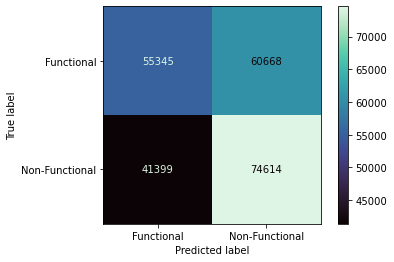

In [23]:
evaluate(logreg, X_train_num_sc_bal, X_test_num_sc_bal, y_train_num_sc_bal, y_test_num_sc_bal)

In [24]:
# numbers-only model performance is slightly above 50%, so room for the "real" model to be better

## Preprocessing